### Movie Generate Prediction

Objective: Predict applicable genres of a movie given its title

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from tqdm import tqdm
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  (accuracy_score, f1_score, precision_score,
    recall_score, confusion_matrix, multilabel_confusion_matrix,
    classification_report
)
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
tqdm.pandas()

In [2]:
# Unzip .gz files
# !gzip -d title.basics.tsv.gz
# !gzip -d title.akas.tsv.gz

In [3]:
# Read tab-separated files
titles1 = pd.read_csv('title.basics.tsv', sep='\t')
titles2 = pd.read_csv('title.akas.tsv', sep='\t')

/var/folders/y4/vx3h67ld48ld9y909666j4wr0000gp/T/ipykernel_22842/1284639287.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles1 = pd.read_csv('title.basics.tsv', sep='\t')
/var/folders/y4/vx3h67ld48ld9y909666j4wr0000gp/T/ipykernel_22842/1284639287.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  titles2 = pd.read_csv('title.akas.tsv', sep='\t')


In [4]:
# Download titles datasets from IMDB
# One of the datasets contains the genres and the other contains language information,
# which we'll use to filter
# down to English movies

# !curl https://datasets.imdbws.com/title.basics.tsv.gz --output title.basics.tsv.gz
# !curl https://datasets.imdbws.com/title.akas.tsv.gz --output title.akas.tsv.gz

In [5]:
titles1.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [6]:
titles2.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


In [7]:
# Based on the documentation at https://www.imdb.com/interfaces/ I thought
# title would be in english if language='en', but that's not the case

# Will merge first and investigate/filter once joined
titles2[titles2['language'] == 'en'].head(5)

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
39,tt0000005,4,Blacksmith Scene,CA,en,imdbDisplay,\N,0
97,tt0000010,6,La sortie de l'usine Lumière à Lyon,CA,en,imdbDisplay,\N,0
117,tt0000012,22,The Arrival of a Train,XWW,en,imdbDisplay,\N,0
119,tt0000012,24,L'arrivée d'un train à La Ciotat,CA,en,imdbDisplay,\N,0
122,tt0000012,27,The Arrival of a Train,XEU,en,imdbDisplay,\N,0


In [8]:
# Join titles1 and titles2 to get the language info from titles2 and genre info from titles1
raw = pd.merge(titles1, titles2, how='inner', left_on='tconst', right_on='titleId')
del titles1, titles2

In [9]:
# Looks like 'primaryTitle' is the english title in this case
raw[raw['titleId'] == 'tt0000010'].head(10)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
76,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,10,Вихід робітників із фабрики,UA,\N,imdbDisplay,\N,0
77,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,11,La salida de la fábrica Lumière en Lyon,ES,\N,imdbDisplay,\N,0
78,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,12,Työntekijät poistuvat Lumière-tehtaalta,FI,\N,\N,informal title,0
79,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,13,A munkaidő vége,HU,\N,imdbDisplay,\N,0
80,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,14,Wyjście robotników z fabryki,PL,\N,imdbDisplay,\N,0
81,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,15,Lumière-fabrikens arbetare,FI,sv,\N,informal title,0
82,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,16,Exiting the Factory,US,\N,imdbDisplay,\N,0
83,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,17,La sortie de l'usine Lumière,FR,\N,alternative,\N,0
84,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,18,La sortie de l'usine Lumière à Lyon,\N,\N,original,\N,1
85,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",tt0000010,19,La sortie des usines Lumière,FR,\N,alternative,\N,0


In [10]:
# Further investigation of language/region combinations
raw[raw['language'] == 'en'].head(10) \
    [['primaryTitle', 'originalTitle', 'title', 'language', 'region']]

,primaryTitle,originalTitle,title,language,region
39,Blacksmith Scene,Blacksmith Scene,Blacksmith Scene,en,CA
97,Leaving the Factory,La sortie de l'usine Lumière à Lyon,La sortie de l'usine Lumière à Lyon,en,CA
117,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XWW
119,The Arrival of a Train,L'arrivée d'un train à La Ciotat,L'arrivée d'un train à La Ciotat,en,CA
122,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XEU
131,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train at La Ciotat,en,XWW
133,The Photographical Congress Arrives in Lyon,Le débarquement du congrès de photographie à Lyon,The Photographical Congress Arrives in Lyon,en,XWW
179,Boat Leaving the Port,Barque sortant du port,Boat Leaving the Port,en,XWW
213,The Sea,Baignade en mer,A Dip in the Sea,en,XWW
221,The Sea,Baignade en mer,The Sea,en,XWW


In [11]:
# Look at the top 20 regions
raw['region'].value_counts().iloc[:20]

DE     4086446
JP     4084968
FR     4084391
IN     4019931
ES     4007418
IT     3986782
PT     3920908
\N     1872985
US     1391685
GB      431687
CA      212943
XWW     167907
AU      126004
BR      114720
MX       92509
RU       92293
GR       90975
PL       86498
FI       85969
SE       74253
Name: region, dtype: int64

In [12]:
# Look at all entries for one titleId with multiple languages
# Notice that the 'title' column is not always in english, even when
# the language is 'en' 
# i.e. title = 'L'arrivée d'un train à La Ciotat' when language = 'en')
raw[raw['titleId'] == 'tt0000012'] \
        .sort_values(by=['language'], ascending=False) \
        .head(10) \
        [['titleId','primaryTitle', 'originalTitle','title', 'language','region']]

,titleId,primaryTitle,originalTitle,title,language,region
109,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Bir trenin La Ciotat garına varışı,tr,TR
130,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Tåget anländer till stationen,sv,FI
120,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,ラ・シオタ駅への列車の到着,ja,JP
131,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train at La Ciotat,en,XWW
119,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,L'arrivée d'un train à La Ciotat,en,CA
122,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XEU
117,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,The Arrival of a Train,en,XWW
129,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,A Chegada de um Trem à Estação,\N,BR
128,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Долазак воза на станицу,\N,RS
127,tt0000012,The Arrival of a Train,L'arrivée d'un train à La Ciotat,Príchod vlaku do stanice La Ciotat,\N,SK


In [13]:
en_regions = ['US', 'GB', 'AUS']

In [14]:
# What about for the regions with a large proportion of english speakers? (US, GB, AUS?)
# Unfortunately most movies in these regions aren't listed as english
raw.query('region in @en_regions')\
    ['language'].value_counts()

\N     1818394
en        4141
es         639
cy          83
yi          63
gd          46
fr           2
hi           1
haw          1
myv          1
cr           1
Name: language, dtype: int64

In [15]:
# Are titles in the XWW region mostly labeled as english? - yes they are!
raw.query('region == "XWW"')['language'].value_counts()

en     165387
\N       1368
es        974
la        109
cmn        48
fr          8
de          3
it          2
ko          2
vi          1
sr          1
zh          1
pt          1
hu          1
ca          1
Name: language, dtype: int64

In [16]:
# Look at titles for the 'XWW' region, which is world-wide release according
# to this forum post:
# https://community-imdb.sprinklr.com/conversations/data-issues-policy-discussions/language-in-titleakastsv/5f4a79f28815453dba91a443

# Looks like this is pretty effective at finding english titles!
raw.query('region == "XWW" and language == "en"') \
    .sample(10) \
    [['titleId','primaryTitle', 'originalTitle','title', 'language','region', 'genres']]

,titleId,primaryTitle,originalTitle,title,language,region,genres
1975981,tt0442827,Real Bout Fatal Fury,Real bout garou densetsu,Real Bout Fatal Fury,en,XWW,"Action,Adventure"
1749600,tt0362020,Worship of Husband,Pati Bhakti,Worship of Husband,en,XWW,\N
33141364,tt9337636,Destiny,Maktoub,Destiny,en,XWW,"Crime,Drama,Romance"
1403965,tt0242002,Szenzáció,Szenzáció,Queen of Spades,en,XWW,\N
22848627,tt24178330,Ninja Box,Ninjabokkusu,Ninja Box,en,XWW,Action
22418317,tt23575410,Happy Ending Romance,Happy Ending Romance,Happy Ending Outside the Fence,en,XWW,"Drama,Romance"
4242077,tt1039997,A Stem,Um Ramo,A Stem,en,XWW,"Drama,Horror,Sci-Fi"
13814663,tt14849498,Until the End of the World: Deleted Scenes,Until the End of the World: Deleted Scenes,Deleted Scenes,en,XWW,"Music,Short"
21179294,tt2190304,Glasha and Kikimora,Glasha i kikimora,Glasha and Kikimora,en,XWW,"Animation,Family,Fantasy"
2962695,tt0860412,Fukeyo harukaze,Fukeyo harukaze,Spring Wind,en,XWW,Drama


In [17]:
# Final dataset combinations that appear to be mostly english titles
df_filters = [
    {
        'region': ['XWW'],
        'language': ['en']
    },
    {
        'region' : ['US', 'AUS', 'GB'],
        'language': ['en', r'\N']
    }
]

In [18]:
temp = []
for filter in df_filters:
    temp.append(
        raw.query('region in @filter["region"] and language in @filter["language"]')
    )
df = pd.concat(temp)
del temp

In [19]:
# Looks good after filtering. Using 'title' column as source of truth
df.sample(20)[['titleId', 'title', 'language','region', 'genres']]

,titleId,title,language,region,genres
25319921,tt4183290,Spark,\N,US,"Short,Thriller"
730423,tt0089931,"Again, Forever",\N,US,Drama
343123,tt0050724,The Moonraker,\N,US,"Action,Adventure,Drama"
21867529,tt22741118,What we do at Shelter Hope Pet Shop,\N,US,"Documentary,Short"
7005275,tt11627936,Beyond Natural,\N,US,Documentary
694570,tt0086165,The Girl from Trieste,en,XWW,"Drama,Thriller"
1828762,tt0388742,Ass Openers 4,\N,US,Adult
1993172,tt0448980,5th Annual Prism Awards,\N,US,\N
1561627,tt0295157,All Night Long,\N,US,Adult
994187,tt0119839,Great Soldiers,en,XWW,"Action,Thriller"


In [20]:
# What about titleType column?
df['titleType'].value_counts()

short           582603
movie           575391
tvEpisode       292162
video           214620
tvSeries        156622
tvMovie          73983
tvMiniSeries     28920
tvSpecial        28767
videoGame        28249
tvShort           6605
Name: titleType, dtype: int64

In [21]:
# Show a few examples of each titleType
for titleType in df['titleType'].unique():
    print(f"Sample of {titleType} content")
    print(
        df[df['titleType'] == titleType] \
            .sample(5)
            [['title', 'language','region', 'genres']]
    )
    print('')

Sample of short content
                                                      title language region  \
24098734                                       Sedatephobia       \N     US   
12922180  On the Rocks: The Unsolved Mysteries of Jack a...       \N     US   
12131190                                   Art Pray Bunnies       \N     US   
33868465               Darling and Ahab in the Great Beyond       \N     US   
1854341                                       The Lone Game       \N     US   

                       genres  
24098734                Short  
12922180                Short  
12131190    Documentary,Short  
33868465         Sci-Fi,Short  
1854341   Drama,Short,Western  

Sample of movie content
                                                      title language region  \
787602                                           Punch-line       en    XWW   
25328302                                          Dixieland       \N     US   
9471166                                     Str

In [22]:
# Let's just keep movie and movie-adjacent content to start
title_types_to_keep = ['movie', 'tvMovie', 'tvMovie', 'tvMiniSeries']
df = df[df['titleType'].isin(title_types_to_keep)]

In [23]:
# Genre analysis - how many are there? What are the most common?
# Genres are stored as a list in each entry, so we'll need to split them out
df['genres_split'] = df['genres'].str.split(pat=',')

In [24]:
# How many titles don't have a genre
num_no_genre = len(df[df['genres'] == r'\N'])
print(f"{num_no_genre} titles don't have a genre")
df = df[df['genres'] != r'\N']
df = df.reset_index(drop=True)

24728 titles don't have a genre


In [25]:
# Split the genres into separate columns
# TODO switch to using multi-label binarizer for faster processing and easier
# reverse transformation
temp = df['genres'].str.get_dummies(sep=',')
genres = list(temp.columns)

In [26]:
temp.head()

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Join genres to df
df = pd.concat([df, temp], axis=1)

In [28]:
# If this is 0 then the genres join was successful
df[genres].isna().sum(axis=0).sum()

0

In [29]:
# Set target variable as the genres
y = df[genres]

In [30]:
df['num_genres'] = df[genres].sum(axis=1)

<AxesSubplot: title={'center': 'Number of Genres per Title'}, xlabel='Number of Genres', ylabel='Number of Titles'>

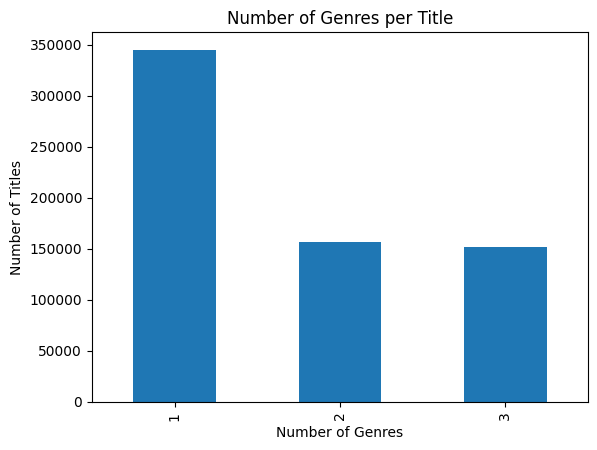

In [31]:
# Most titles have 1 genre, but some have 2 or 3
df['num_genres'].value_counts().plot(
    kind='bar',
    title='Number of Genres per Title',
    xlabel='Number of Genres',
    ylabel='Number of Titles',
)

In [32]:
# Investigate some sample titles - what cleaning is required?
df['title'].sample(20)

531599                      The Morning After
293920                                  Risko
87523                         The Lucky Bride
61792                               Head Cold
163606                   The Castle of Purity
563580                       Perfect Partners
325363    Conjuror: The Crimes of Jason Mewes
160570              In the Folds of the Flesh
523983                      Plastic Breakfast
497992                                  Shhhh
552065                                   Cave
112617                         The Southerner
405315                   Homeless in Paradise
302399                        Office Outbreak
166558                                    Mel
260570                              Loco Love
74297                  Exploratory Interviews
154368                     Shakespeare-Wallah
483815                 The Inventor of Dreams
300728                                Paprika
Name: title, dtype: object

In [33]:
# Preprocess / the title text

# Remove numberings (i.e. 1st, 2nd, 3rd, etc.) first so the letters aren't
# stranded after removing the numbers (i.e. 1st -> st, 2nd -> nd)
numbering_re = re.compile(r"(\d+(?:st|nd|rd|th))")

# Keep only alpha characters
alpha_re = re.compile(r"[^a-z]+")

# Remove multiple spaces
multi_space_re = re.compile(r"\s+")

# stop_words = set(stopwords.words('english'))
# Use an abbreviated stopword list to preserve as much contextual information as possible
stop_words = ['for', 'the', 'a', 'an', 'in', 'of', 'as', 'at', 'by', 'for', 'on',
    'and', 'to']

# Don't forget to download wordnet if you haven't already!
# nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Converting to lowercase, keeping only alpha characters, and lemmatizing

    Only removing a select number of stopwords since many stopwords may
    contain useful contextual information for classification
    """
    # Convert unicode to ascii version (to preserve words like Pokémon)
    text = unidecode(text)

    # Lowercase, remove numberings (i.e. 1st, 2nd)
    text = text.lower()
    text = numbering_re.sub(" ", text)

    # Remove apostrophes directly as they cause issues with the tokenizer
    text = text.replace("'", "")

    # Keep only alpha characters
    text = alpha_re.sub(" ", text)

    # Turn multiple spaces into a single space
    text = multi_space_re.sub(" ", text)

    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Try without removing stop words first since they may be important for classification
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [34]:
df['title_cleaned'] = df['title'].progress_apply(clean_text)

100%|██████████| 653566/653566 [00:30<00:00, 21212.95it/s]


In [35]:
df.sample(20)[['title', 'title_cleaned', 'genres']]

,title,title_cleaned,genres
138657,The Assassin,[assassin],"Crime,Mystery,Thriller"
299751,Measure for Measure,"[measure, measure]",Drama
214463,Have Blower Will Travel,"[have, blower, will, travel]",Adult
272514,Hansel and Gretel,"[hansel, gretel]","Adventure,Drama,Family"
299659,National Anthem,"[national, anthem]","Drama,War"
548497,The Optimist,[optimist],Comedy
16902,Departure,[departure],"Comedy,Crime,Drama"
376641,Three Lives,"[three, life]","Family,Fantasy"
391057,Sharp,[sharp],Action
474194,Dragonetti - Ghost Assassin,"[dragonetti, ghost, assassin]","Action,Adventure,Horror"


In [36]:
def dummy_function(text):
    """
    Used to run TfIdf with preapplied tokenization and preprocessing
    """
    return text

In [37]:
# Vectorize the text
vectorizer = TfidfVectorizer(
    tokenizer=dummy_function,
    preprocessor=dummy_function,
    analyzer='word',
    token_pattern=None,
    min_df=3,
)

X = vectorizer.fit_transform(df['title_cleaned'])

In [38]:
# Check our cleaning and tokenization by inspecting most frequent tfidf scores
# Many of the top terms would have been removed had we used a more traditional
# stopword list
tfidf_df = pd.DataFrame(
    {
        'tfidf_score' : np.array(X.sum(axis=0)).T[:,0],
    },
    index=vectorizer.get_feature_names_out().T,
)

tfidf_df.sort_values(by='tfidf_score', ascending=False).head(25)

,tfidf_score
love,5745.040338
my,3783.835086
man,3716.125636
life,3573.566670
girl,3312.658226
night,3309.699735
story,3253.049859
day,3082.138818
woman,2855.988216
i,2835.673623


In [81]:
def query_titles(data=df, query_token=None, column='title_cleaned'):
    """
    Check if a token is in the cleaned title. Used to check token context
    """
    return data[data[column].apply(lambda x: str(query_token).lower() in x)]

## Example function usage
# query_token = 'hook'
# query_titles(query_token=query_token).sample(20)[['title', 'title_cleaned', 'genres']]

,title,title_cleaned,genres
207627,The Hook,[hook],"Horror,Mystery"
276719,Hooked: The Legend of Demetrius Hook Mitchell,"[hooked, legend, demetrius, hook, mitchell]",Documentary
466477,Red Hook,"[red, hook]",Drama
65920,"Hook, Line & Sinker","[hook, line, sinker]",Drama
625894,Fish and Hook,"[fish, hook]","Adventure,Comedy"
242741,Sky Hook,"[sky, hook]","Drama,War"
62803,By Hook and Crook,"[hook, crook]","Comedy,Crime"
244702,Sandy Hook Lingerie Party Massacre,"[sandy, hook, lingerie, party, massacre]","Comedy,Horror"
249188,The Hook-Up,"[hook, up]","Comedy,Romance"
376735,Spitting Game: The College Hook Up Culture,"[spitting, game, college, hook, up, culture]",Documentary


In [40]:
def evaluate_model(model_name, y_true, y_pred):
    pass

In [41]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [42]:
X_train = vectorizer.transform(train['title_cleaned'])
X_test = vectorizer.transform(test['title_cleaned'])

# Scale the data (only by variance since the input data is a sparse matrix)
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = train[genres]
y_test = test[genres]

In [43]:
# OneVersusRest Naive Bayes classifier
nb_clf = OneVsRestClassifier(MultinomialNB(), verbose=1)
nb_clf.fit(X_train, y_train)
y_nb_pred = nb_clf.predict(X_test)

# nb_cv = GridSearchCV(
#     clf,
#     param_grid={},
#     verbose=1,
#     cv=5,
#     n_jobs=-1
# )
# nb_cv.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    1.5s finished


In [44]:
y_nb_pred.shape

(130714, 28)

In [45]:
# There are many test titles with no predicted genres... :(
y_nb_pred.max(axis=1).sum()

126460

In [46]:
# Naive Bayes classification report
cols = ['micro avg', 'macro avg', 'weighted avg']
pd.DataFrame(classification_report(y_test, y_nb_pred, target_names=genres, output_dict=True))[cols].reset_index(names='metric')

/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metric,micro avg,macro avg,weighted avg
0,precision,0.189205,0.135315,0.301824
1,recall,0.666408,0.622064,0.666408
2,f1-score,0.294731,0.202366,0.388976
3,support,222940.000000,222940.000000,222940.000000


In [65]:
classifiers = [
    {
        'name' : 'Naive Bayes',
        'clf' : OneVsRestClassifier(MultinomialNB(), verbose=1, n_jobs=-1)
    },
    {
        'name' : 'Logistic Regression',
        'clf' : OneVsRestClassifier(LogisticRegression(max_iter=1000),
                                                       verbose=1,
                                                       n_jobs=-1)
    },
    {
        'name' : 'Linear SVC',
        'clf' : OneVsRestClassifier(LinearSVC(max_iter=1000),
                                              verbose=1,
                                              n_jobs=-1)
    },
    {
        'name' : 'K-Nearest Neighbors',
        'clf' : KNeighborsClassifier(n_jobs=-1)
    },
    {
        'name' : 'Random Forest',
        'clf' : RandomForestClassifier(verbose=1, n_jobs=-1)
    },
    {
        'name' : 'Gradient Boosted Trees',
        'clf' : OneVsRestClassifier(GradientBoostingClassifier(),
                                    verbose=1,
                                    n_jobs=-1)
    },
]

In [66]:
# TODO Add cross validation to find best hyperparameters
def eval_model(params):
    clf = params['clf']
    print(f"Training model: {params['name']}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cols = ['micro avg', 'macro avg', 'weighted avg']
    results = pd.DataFrame(classification_report(y_test, y_pred, target_names=genres, output_dict=True))[cols].reset_index(names='metric')
    results['model'] = params['name']

    # save model to dictionary
    params['model'] = clf
    return results

In [67]:
results_df = []
for classifier in classifiers:
    try:
        results_df.append(eval_model(classifier))
    except Exception as e:
        print(f"Error training model: {classifier['name']}")
        print(e)
        continue
    
results_df = pd.concat(results_df)
results_df

Training model: Naive Bayes


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    2.7s finished
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model: Logistic Regression


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   43.1s finished
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to contr

Training model: Linear SVC


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/eddie/Documents/development/personal

Training model: K-Nearest Neighbors


/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model: Random Forest


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 59.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   28.4s finished
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training model: Gradient Boosted Trees


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  7.9min finished
/Users/eddie/Documents/development/personal/movie_genres/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metric,micro avg,macro avg,weighted avg,model
0,precision,0.189205,0.135315,0.301824,Naive Bayes
1,recall,0.666408,0.622064,0.666408,Naive Bayes
2,f1-score,0.294731,0.202366,0.388976,Naive Bayes
3,support,222940.000000,222940.000000,222940.000000,Naive Bayes
0,precision,0.591570,0.496504,0.577754,Logistic Regression
1,recall,0.283592,0.170918,0.283592,Logistic Regression
2,f1-score,0.383391,0.245526,0.359926,Logistic Regression
3,support,222940.000000,222940.000000,222940.000000,Logistic Regression
0,precision,0.325540,0.209163,0.325985,Linear SVC
1,recall,0.310227,0.200633,0.310227,Linear SVC


In [102]:
# Random forest is pretty clearly the winner here
results_df.query("metric == 'f1-score'")

,metric,micro avg,macro avg,weighted avg,model
2,f1-score,0.294731,0.202366,0.388976,Naive Bayes
2,f1-score,0.383391,0.245526,0.359926,Logistic Regression
2,f1-score,0.317699,0.204546,0.317766,Linear SVC
2,f1-score,0.390739,0.214706,0.363901,K-Nearest Neighbors
2,f1-score,0.562788,0.448860,0.553922,Random Forest
2,f1-score,0.061640,0.074662,0.060224,Gradient Boosted Trees


In [ ]:
# Retrain a random forest model with the full dataset

X = vectorizer.transform(df['title_cleaned'])
y = df[genres]

# Recale the data (only by variance since the input data is a sparse matrix)
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)

# Random forest is 4th index in the classifiers list
rf_clf = classifiers[4].fit(X, y)

In [103]:
classifiers[4]

{'name': 'Random Forest',
 'clf': RandomForestClassifier(n_jobs=-1, verbose=1),
 'model': RandomForestClassifier(n_jobs=-1, verbose=1)}

In [96]:
clf = classifiers[4]['model']
title = 'The Lord of the Rings: The Return of the King'
title = clean_text(title)
vectorized = vectorizer.transform([title])
vectorized = scaler.transform(vectorized)
prediction = clf.predict(vectorized)
prediction = pd.DataFrame(prediction, columns=genres)
prediction = prediction.T[prediction.T[0] == 1].index.tolist()
prediction

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Save out vectorizer, scaler, 

In [90]:
# Come back later to add ROC curves and threshold tuning

[array([[0.86058159, 0.13941841]]),
 array([[0.78, 0.22]]),
 array([[0.81112454, 0.18887546]]),
 array([[0.9824707, 0.0175293]]),
 array([[0.94833333, 0.05166667]]),
 array([[0.74672611, 0.25327389]]),
 array([[0.97351515, 0.02648485]]),
 array([[0.91521057, 0.08478943]]),
 array([[0.77359804, 0.22640196]]),
 array([[0.93885631, 0.06114369]]),
 array([[0.96, 0.04]]),
 array([[1., 0.]]),
 array([[1., 0.]]),
 array([[0.96, 0.04]]),
 array([[1., 0.]]),
 array([[0.95, 0.05]]),
 array([[1., 0.]]),
 array([[0.95284524, 0.04715476]]),
 array([[1., 0.]]),
 array([[1., 0.]]),
 array([[0.91239899, 0.08760101]]),
 array([[0.999, 0.001]]),
 array([[1., 0.]]),
 array([[1., 0.]]),
 array([[1., 0.]]),
 array([[0.93284524, 0.06715476]]),
 array([[1., 0.]]),
 array([[0.98, 0.02]])]

In [ ]:
### Example of multi-label classification

# from sklearn.datasets import make_multilabel_classification
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# from sklearn.model_selection import train_test_split

# # Build a synthetic dataset
# X, y = make_multilabel_classification(
#     n_samples=100, n_labels=3, n_features=5, n_classes=4
# )

# y[0:4]